<a href="https://colab.research.google.com/github/taiga0803/qmcro_second/blob/main/Qmacro_%E5%BE%8C%E5%8D%8A%E8%AA%B2%E9%A1%8C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
import numpy as np
from scipy.stats import norm

def tauchen(n, mu, rho, sigma):
    # Function to implement Tauchen's method for discretizing a continuous state space
    # Inputs:
    # n: グリッドポイント数
    # mu: AR(1) processの平均
    # rho: AR(1) 係数
    # sigma: 誤差項の標準偏差
    # Outputs:
    # transition_matrix: n x n transition matrix
    # state_space: n x 1 vector of state space points

    m = 1 / np.sqrt(1 - rho**2) #AR(1)過程の定常状態の標準偏差を計算し、変数mに代入します。これは後で遷移確率を計算するために使用されます

    # Compute the state space
    state_space = np.linspace(mu - m*sigma, mu + m*sigma, n) #np.linspace()を使って、mu - m*sigmaからmu + m*sigmaまでの範囲を等間隔に分割し、n個のグリッドポイントを持つ状態空間を計算し、state_spaceに代入します。

    # Compute the distance between grid points
    d = (state_space[n-1] - state_space[0]) / (n - 1) #状態空間内のグリッドポイント間の距離dを計算します。これは、グリッドポイントの範囲を最初と最後のグリッドの数で分割したものです。

    # Compute the transition probabilities
    transition_matrix = np.zeros((n, n)) #遷移行列transition_matrixをn x nのゼロ行列で初期化します
    for i in range(n): # today state n回ループする
        for j in range(n): # tomorrow state
            if j == 0: # prob going to the lower limit
                transition_matrix[i, j] = norm.cdf((state_space[0] - rho*state_space[i] + d/2) / sigma)
            elif j == n-1: # prob going to the upper limit
                transition_matrix[i, j] = 1 - norm.cdf((state_space[n-1] - rho*state_space[i] - d/2) / sigma)
            else:
                z_low = (state_space[j] - rho*state_space[i] - d/2) / sigma # the lower bound
                z_high = (state_space[j] - rho*state_space[i] + d/2) / sigma # the higher bound
                transition_matrix[i, j] = norm.cdf(z_high) - norm.cdf(z_low)

#2重のループを使用して、transition_matrix内の各要素を計算します。transition_matrix[i, j]は、状態iから状態jに遷移する確率を表します。
#j == 0の場合: これは状態空間の最初のグリッドポイントに対応します。遷移確率は下限に達する確率として計算されます。
#j == n-1の場合: これは状態空間の最後のグリッドポイントに対応します。遷移確率は上限に達する確率として計算されます。
#それ以外の場合: これは状態空間の中間のグリッドポイントに対応します。遷移確率は上限と下限の差を正規分布の累積確率関数を用いて計算されます。

    return transition_matrix, state_space #計算されたtransition_matrixとstate_spaceを返します。これで関数tauchenの処理が完了します。

In [11]:
import numpy as np

# function to comile parameters into one thing "parameter"
def setPar(
    sigma = 1.50, # risk aversion　リスク回避度
    beta = 0.98, # subjective discount factor　主観的割引率
    delta = 0.03, # depreciation　資本減耗率
    alpha = 0.25, # capital’s share of income　資本収益率の所得シェア
    rho = 0.6, # labor productivity persistence　労働生産性の持続性
    a_l = 0, # lower bound of asset grids　資産グリッドの下限
    a_u = 20, # upper bound of asset grids　資産グリッドの上限
    NH = 2, # number of grids of h　労働生産性のグリッドの数
    NA = 401, # number of grids of a　資産のグリッドの数
    tau = 0.05 #資本税率
    ):

    # labor productivity variance.
    sigma_eps = np.sqrt(0.6*(1-rho**2)) #労働生産性の分散sigma_epsを計算しています。

    # making grids for ln h and solving for income transition probability using Tauchen's method.
    pi, h = tauchen(NH, -0.7, rho, sigma_eps) # 労働生産性のグリッドをTauchenのメソッドを使って生成し、労働生産性の遷移確率行列piと労働生産性の値hを取得
    h = np.exp(h) # hを対数から通常の値に変換しています

    # derive the stationary distribution from income transition process

    probst = np.ones((NH))/NH # setting the guess probability to a uniform distribution 初期推定: 定常分布を求めるための初期推定を行います。ここでは、労働生産性のグリッド数 NH に等しい確率の値を持つ一様な分布を仮定
    test = 10.0 # initialize the distance to a big number

    while test > 1e-8: # loop until convergence of the stationary distribution
        probst_new = np.zeros((NH)) # initialize new distribution
        for ih in range(NH): # today h
            for ihp in range(NH): # tomorrow h
                probst_new[ihp] += pi[ih, ihp]*probst[ih]

        test = np.max(np.abs(probst_new - probst)) # calculate the difference between the guess and the new distribution
        probst = probst_new # updating the guess

    HH = np.sum(h*probst) # aggregate effective labor 労働生産性hと定常分布probstを用いて、労働の総量HHを計算しています

	  # create dictionary with parameters
    param = {}
    param['sigma'] = sigma; param['beta'] = beta; param['delta'] = delta;
    param['alpha'] = alpha; param['probst'] = probst;
    param['a_l'] = a_l; param['a_u'] = a_u; param['NH'] = NH; param['NA'] = NA;
    param['pi'] = pi; param['h'] = h; param['HH'] = HH; param['tau'] = tau;

    return param


In [12]:
def solve_household_gs(param, r, w, KK):

    # opening the box of "param" to some parameters
    a_l = param['a_l']; a_u = param['a_u']; pi = param['pi']; delta = param['delta'];
    beta = param['beta']; sigma = param['sigma']; h = param['h']; NA = param['NA'];
    NH = param['NH']; tau = param['tau'];
    T = KK*r*tau

    # Create a grid of asset holdings
    a = np.linspace(a_l, a_u, NA)

    # Initialize the utility function to a large negative number for zero or negative consumption
    util = np.full((NA, NA, NH), -10000.0)

    # Calculate utility if the agent chooses asset a[iap] for each asset combination a[ia] and income shock h[ih]
    for ia in range(NA):
        for iap in range(NA):
            for ih in range(NH):
                cons = w*h[ih] + (1.0 + r - r*tau)*a[ia] - a[iap] + T
                if cons > 0: # count only if consumption is positive
                    util[iap, ia, ih] = cons**(1.0-sigma)/(1.0-sigma)


    # Initialize some variables
    v = np.zeros((NA, NH))
    aplus = np.zeros((NA, NH))
    c = np.zeros((NA, NH))
    v_new = np.zeros((NA, NH))
    iaplus_new = np.full((NA, NH), -10000)
    iaplus = np.full((NA, NH), -10000)
    reward = np.zeros((NA, NA, NH))

    # Iterate on Bellman's equation and get the decision rules and the value function at the optimum
    test = 10
    while test != 0: # loop until policy function converges
        for ia in range(NA):
            for ih in range(NH):
                reward[:, ia, ih] = util[:, ia, ih]
                for ihp in range(NH):
                    reward[:, ia, ih] += beta*pi[ih, ihp]*v[:, ihp]

        # Finding max of reward
        for ia in range(NA):
            for ih in range(NH):
                v_new[ia, ih] = np.max(reward[:, ia, ih]) # finding the maximal value
                iaplus_new[ia, ih] = np.argmax(reward[:, ia, ih]) # finding the index of the maximizer

        test = np.max(iaplus_new - iaplus) # stop if iaplus converges
        v = v_new
        iaplus = iaplus_new.copy()

    aplus = a[iaplus]

    # optimal consumption
    for ia in range(NA):
        for ih in range(NH):
            c[ia, ih] = w*h[ih] + (1.0 + r - r*tau)*a[ia] - aplus[ia, ih] + T

    return aplus, iaplus, c

In [13]:
def get_distribution(param, decisions):

    a_l = param['a_l']; a_u = param['a_u']; pi = param['pi'];
    NA = param['NA']; NH = param['NH'];
    iaplus = decisions[1]

    # Generate a linearly spaced vector of NA values between a_l and a_u
    a = np.linspace(a_l, a_u, NA)

    test = 10 # Initialize a test value to be greater than 10^-8
    mu = np.ones((NA, NH)) / NA / NH # Initialize the distribution mu to be uniform

    # Loop until the test value is less than 10^-8
    while test > 1e-8:
        mu_new = np.zeros((NA, NH)) # Initialize a new distribution mu_new to be all zeros
        # Loop over all values of a, h, and h'
        for ia in range(NA):
            for ih in range(NH):
                for ihp in range(NH):
                    # Update mu_new using the interpolation indices, blending coefficients, and probabilities
                    mu_new[iaplus[ia, ih], ihp] += pi[ih, ihp] * mu[ia, ih]
        test = np.max(np.abs(mu_new - mu)) # Calculate the maximum difference between mu_new and mu
        mu = mu_new # Update mu to be mu_new

    return mu

In [14]:
def model_solution(param):

    alpha = param['alpha']
    delta = param['delta']
    HH = param['HH'] #HHは個人個人の労働者の生産性の平均

    phi = 0.2 # updating share
    toler = 1e-3 # warning: this doens't converge if tolerance is too small
    test = 10 # initial difference
    KK = 10.0 # initial capital

    print('ITERATING ON KK')
    print('')
    print('  metric    Kold      Knew')

    while test > toler:

        # Step 1
        # calculate rental rate of capital and w from firm FOC

        w = (1-alpha) * KK**(alpha) * HH**(-alpha)
        r = (alpha) * KK**(alpha-1) * HH**(1-alpha) - delta

        ####################################################
        # Step 2: Solving for households optimization (policy function of assets)
        ####################################################

        decisions = solve_household_gs(param, r, w, KK)

        aplus = decisions[0] # note that the first component (index 0) of decisions is defines as aplus

        ####################################################
        # Step 3: Loop for finding eq distribution and capital
        ####################################################

        # eq distribution

        mu = get_distribution(param, decisions)

        # new aggregate capital

        KK_new = np.sum(mu*aplus)

        ####################################################
        # Loop for finding eq capital
        ####################################################

        # form metric and update KK

        test = abs((KK_new - KK)/KK) # loop until K converges
        print(['{:.4f}'.format(test), '{:.4f}'.format(KK), '{:.4f}'.format(KK_new)])
        KK = phi*KK_new + (1-phi)*KK # update K

    return decisions, r, w, KK, HH, mu

In [15]:
import matplotlib.pyplot as plt

param = setPar()
(decisions, r, w, KK, HH, mu) = model_solution(param)

print(KK,w,r)

ITERATING ON KK

  metric    Kold      Knew
['0.5660', '10.0000', '4.3398']
['0.4077', '8.8680', '5.2521']
['0.1795', '8.1448', '6.6830']
['0.0074', '7.8524', '7.9104']
['0.0002', '7.8640', '7.8625']
7.8637379482131875 1.296078556201679 0.018442865334150668


Text(0, 0.5, '% OF AGENTS')

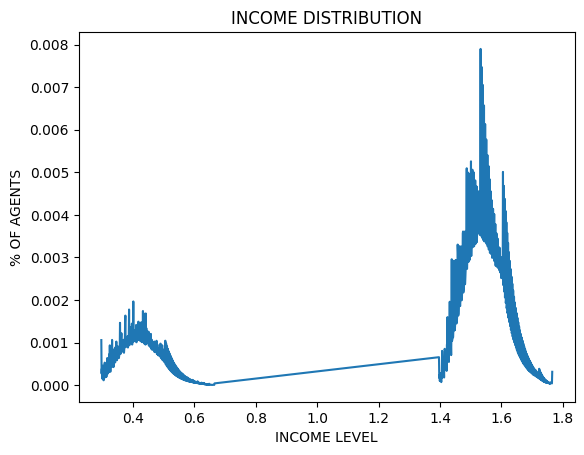

In [16]:
h = param['h']
a_l = param['a_l']; a_u = param['a_u']; NA = param['NA'];
a = np.linspace(a_l, a_u, NA)


# calculate income distribution for each grid
income = np.array([(r*a + w*h[0]), (r*a + w*h[1])])
# # transpose income
income = income.T
# # sorting the income after flattening "income"
# pinc, index = np.sort(income.flatten('F')), np.argsort(income.flatten('F'))
# plambda = mu.flatten('F')
# #

# sort with regard to the 1st argument of zip
zip_lists = zip(income.flatten('F'), mu.flatten('F'))
# sort upwards
zip_sort = sorted(zip_lists)
# unzip
pinc, pmu = zip(*zip_sort)

plt.plot(pinc, pmu)
plt.title('INCOME DISTRIBUTION')
plt.xlabel('INCOME LEVEL')
plt.ylabel('% OF AGENTS')

In [17]:
def gini_coefficient(distribution):

    n = len(distribution)
    distribution = np.sort(distribution)
    gini = 0

    for i in range(n):
        gini += (2 * (i + 1) - n - 1) * distribution[i]

    gini /= (n * np.sum(distribution))

    return gini

h = param['h']
a_l = param['a_l']; a_u = param['a_u']; NA = param['NA'];
a = np.linspace(a_l, a_u, NA)
income = np.array([(r*a + w*h[0]), (r*a + w*h[1])])
income = income.T

zip_lists = zip(income.flatten('F'), mu.flatten('F'))
zip_sort = sorted(zip_lists)
pinc, pmu = zip(*zip_sort)

gini_coeff = gini_coefficient(pinc)

print('Gini Coefficient:', gini_coeff)

Gini Coefficient: 0.29658397079626686


In [18]:
def calculate_income(param, decisions, w, r):
    a_l = param['a_l']
    a_u = param['a_u']
    NA = param['NA']
    NH = param['NH']
    aplus = decisions[0]
    mu = get_distribution(param, decisions)
    a = np.linspace(a_l, a_u, NA)

    # Calculate individual income
    income = np.zeros((NA, NH))
    for ia in range(NA):
        for ih in range(NH):
            income[ia, ih] = w * param['h'][ih] + (1.0 + r - r * param['tau']) * a[ia] - aplus[ia, ih] + r * param['tau'] * a[ia]

    # Calculate GDP
    GDP = np.sum(income * mu)

    return GDP

# param, decisions, r, w, KK, HH, muは先に計算した値です
GDP = calculate_income(param, decisions, w, r)
print("GDP:", GDP)


GDP: 1.287885638420597
